In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

In [3]:
spx = yf.download('^GSPC', start = '2000-01-01', end = '2022-12-27')

[*********************100%***********************]  1 of 1 completed


In [4]:
spx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


<Axes: xlabel='Date'>

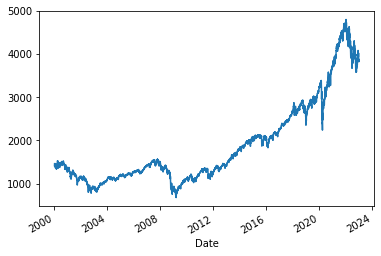

In [5]:
spx['Adj Close'].plot()

<Axes: xlabel='Date'>

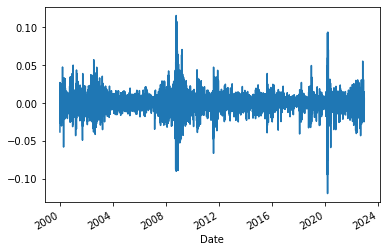

In [6]:
# Plotando a serie estacionaria

ret_spx = spx['Adj Close'].pct_change()
ret_spx = ret_spx.dropna()
ret_spx.plot()

<Axes: xlabel='Adj Close', ylabel='Density'>

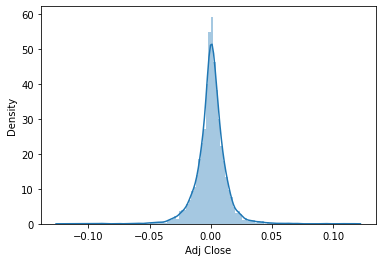

In [7]:
# Verificando a distribuição dos retornos

sns.distplot(ret_spx,
             hist = True,
             norm_hist = True,
             kde=True,
             hist_kws={"range": [-0.05,0.05]})

In [8]:
# Verifcando a Estacionariedade com Dickey-Fuller

from statsmodels.tsa.stattools import adfuller

result = adfuller(ret_spx)
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')
print('Critical Values:')
 
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[1] < 0.05:
    print('SPX é uma serie estacionaria')
else:
    print('SPX é uma serie Não estacionaria')

Teste ADF:-18.422220293575368
p-valor:2.1753539229400137e-30
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
SPX é uma serie estacionaria


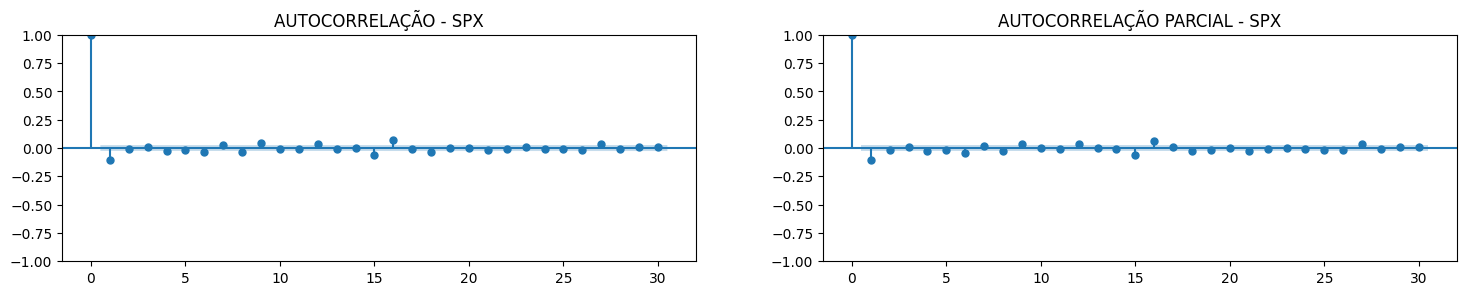

In [9]:
# Autocorrelação SPX

fig, axes = plt.subplots(1,2,figsize=(18,3), dpi= 100)
plot_acf(ret_spx.tolist(), lags=30, ax=axes[0], title = 'AUTOCORRELAÇÃO - SPX');
plot_pacf(ret_spx.tolist(), lags=30, ax=axes[1], title = 'AUTOCORRELAÇÃO PARCIAL - SPX');

In [10]:
# Usando um modelo Arima para pergar os residuos

model = auto_arima(ret_spx, start_p=1, start_q=1,test='adf',max_p=5, max_q=5,m=1,d=1,seasonal=False,start_P=0,D=None,
                   trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29662.703, Time=0.86 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31681.046, Time=0.91 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29664.702, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-32527.521, Time=1.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-32888.273, Time=1.92 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-33127.839, Time=2.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-33257.315, Time=5.55 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-34065.786, Time=8.68 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-34244.758, Time=6.69 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-34100.839, Time=5.87 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-34028.364, Time=8.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-34145.816, Time=6.79 sec
 ARIMA(5,1,2)(0,0,0

<Axes: xlabel='Date'>

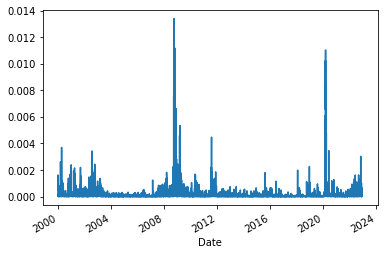

In [11]:
# Gerando os residuos ao quadrado

resid2 = model.resid()**2
resid2.plot()

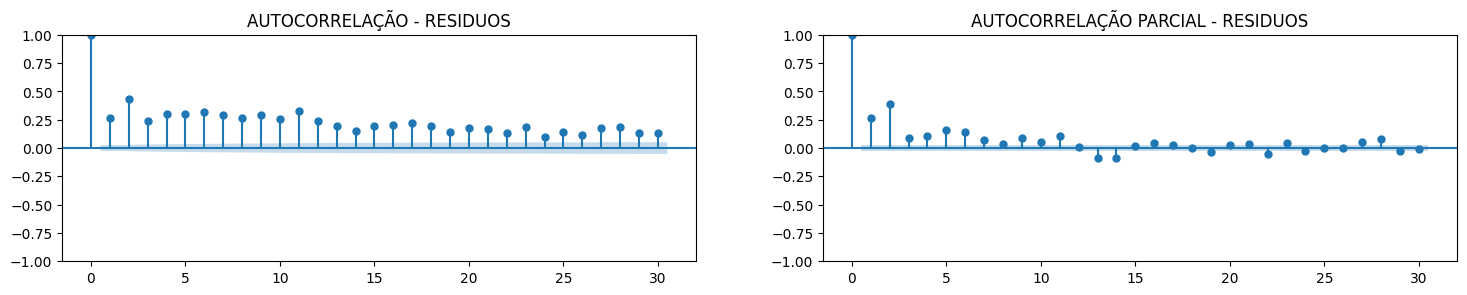

In [12]:
# Autocorrelação dos residuos

fig, axes = plt.subplots(1,2,figsize=(18,3), dpi= 100)
plot_acf(resid2.tolist(), lags=30, ax=axes[0], title = 'AUTOCORRELAÇÃO - RESIDUOS');
plot_pacf(resid2.tolist(), lags=30, ax=axes[1], title = 'AUTOCORRELAÇÃO PARCIAL - RESIDUOS');

<Axes: ylabel='Density'>

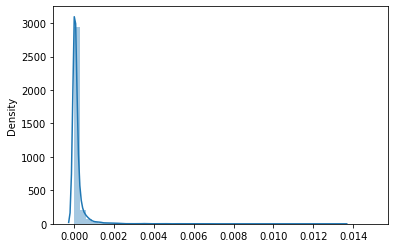

In [13]:
# Distribuição dos residuos

sns.distplot(resid2,
             hist = True,
             norm_hist = True,
             kde=True,
             hist_kws={"range": [-0.0,0.015]})

In [14]:
# Modelo Garch

garch_model = arch_model(resid2, mean='Zero', vol='GARCH', p=1, q=1, dist = 'normal')
garch_model_fit = garch_model.fit()
garch_model_fit.summary

Iteration:      1,   Func. Count:      4,   Neg. LLF: -40389.11891132135
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -40389.118953568126
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1


c:\Users\fgomes\Anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                40389.1
Distribution:                  Normal   AIC:                          -80772.2
Method:            Maximum Likelihood   BIC:                          -80752.3
                                        No. Observations:                 5782
Date:                Fri, Oct 13 2023   Df Residuals:                     5782
Time:                        16:34:19   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.9445

<Axes: xlabel='Date'>

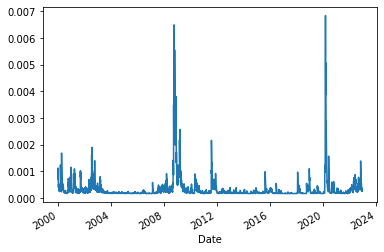

In [19]:
# Plotando o modelo

vol = garch_model_fit.conditional_volatility
vol.plot()